In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations
import tensorflow as tf  # For machine learning and deep learning functionalities
from tensorflow.keras.preprocessing import image_dataset_from_directory  # For creating a dataset from a directory of images
from tensorflow.keras.callbacks import Callback, EarlyStopping  # For model training callbacks
import pathlib  # For working with file paths
from imgaug import augmenters as iaa  # For image augmentation techniques
from google.colab import drive  # For Google Colab-specific functionalities

In [2]:
# Installing and importing PyDrive and other necessary libraries
!pip install -U -q PyDrive  # Upgrading or installing PyDrive library
from pydrive.auth import GoogleAuth  # Importing GoogleAuth for Google Drive authentication
from pydrive.drive import GoogleDrive  # Importing GoogleDrive for Google Drive file manipulation
from google.colab import auth  # Importing auth for Google Colab authentication
from oauth2client.client import GoogleCredentials  # Importing GoogleCredentials for OAuth2 authentication

In [3]:
auth.authenticate_user()  # Authenticating the user
gauth = GoogleAuth()  # Initializing GoogleAuth object
gauth.credentials = GoogleCredentials.get_application_default()  # Setting credentials using GoogleCredentials
drive = GoogleDrive(gauth)  # Creating a GoogleDrive object using the authenticated credentials

In [4]:
downloaded = drive.CreateFile({'id':'1nXonO3oXiGyjER-WWv5HjDityS6UnVxd'})
downloaded.GetContentFile('Money_Dataset.zip')  # Downloading a file with the specified ID and saving it as 'Rempah.zip'

In [6]:
from zipfile import ZipFile

with ZipFile('Money_Dataset.zip', 'r') as zipObj:
    zipObj.extractall('Money_Dataset')


In [7]:
# Path to the dataset folder on Google Drive
DATASET_PATH = '/content/Money_Dataset/Dataset_Fitur_Uang'

# Set your image size and batch size
IMG_SIZE = [128, 128]
BATCH_SIZE = 16

# Create a Path object for the dataset
data_dir = pathlib.Path(DATASET_PATH)

# Use image_dataset_from_directory to load the dataset
dataset = image_dataset_from_directory(data_dir,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        interpolation='nearest',
                                        label_mode='categorical')

# Split the dataset into training and validation sets
class_names = dataset.class_names
class_number = len(class_names)
nbr_batches = tf.data.experimental.cardinality(dataset)

Found 2355 files belonging to 14 classes.


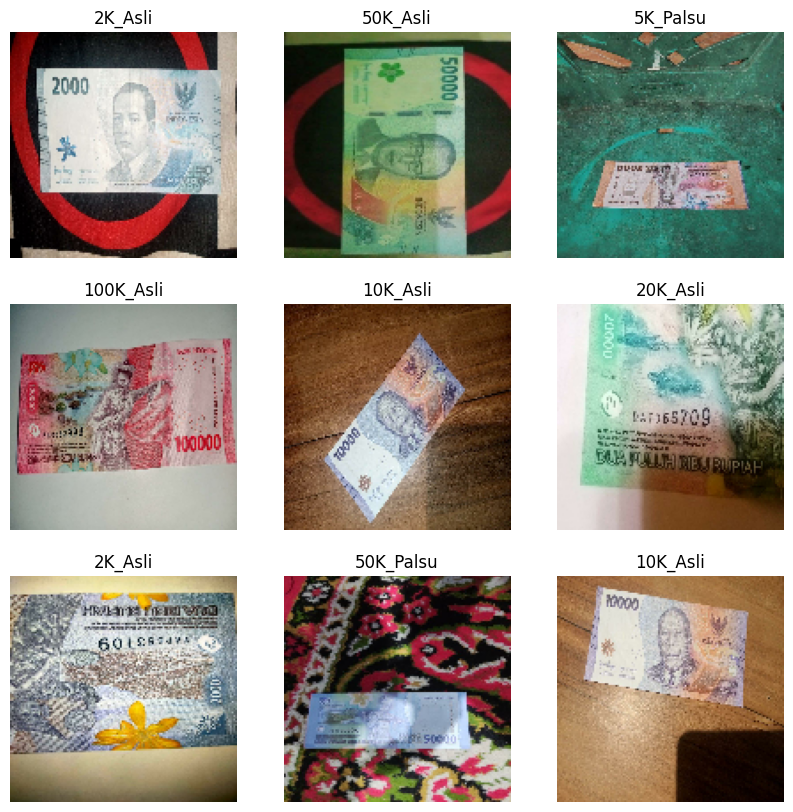

In [8]:
# Take 20% for validation
validation_dataset = dataset.take(nbr_batches // 5)
train_dataset = dataset.skip(nbr_batches // 5)

# Visualize some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')

# Data augmentation
augmenter = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.MotionBlur((3, 4)), name='SometimesMotionBlur'),
    iaa.Sometimes(0.5, iaa.GaussianBlur((0.0, 0.75)), name='SometimesGaussianBlur'),
    iaa.GammaContrast((0.7, 1.5)),
    iaa.MultiplySaturation((0.9, 1.5)),
    iaa.MultiplyAndAddToBrightness(),
    iaa.Fliplr(p=0.5),
    iaa.Affine(scale=(1, 1.3),
              translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
              rotate=(-25, 25))
])

def augmentation_function(images, labels):
    img_dtype = images.dtype
    img_shape = tf.shape(images)
    images = tf.numpy_function(augmenter.augment_images,
                               [images],
                               img_dtype)
    images = tf.reshape(images, shape=img_shape)
    return images, labels

# Apply augmentation to the training dataset
train_dataset = train_dataset.map(augmentation_function, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
# Preprocess and prefetch the datasets
def preprocess_dataset(dataset):
    return dataset.map(lambda img, label: (tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(img, tf.float32)), label),
                       num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = preprocess_dataset(train_dataset)  # Preprocess and prefetch the training dataset
validation_dataset = preprocess_dataset(validation_dataset)  # Preprocess and prefetch the validation dataset

# Load MobileNetV2 as the base model
IMG_SHAPE = (*IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True  # Allow fine-tuning of the base model

# Fine-tune only the later layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # Freeze layers up to the specified index

# Build the model with increased dropout, batch normalization, and L2 regularization
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(class_number, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                        

In [11]:
# Use a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,  # Initial learning rate
    decay_steps=10000,  # Decay steps
    decay_rate=0.9  # Decay rate
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),  # Compile the model with Adam optimizer and learning rate schedule
              loss=tf.keras.losses.CategoricalCrossentropy(),  # Categorical crossentropy loss for multi-class classification
              metrics=['accuracy'])  # Monitoring accuracy during training

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define custom callback to stop training when both training and validation accuracies exceed 0.95
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.95:
            self.model.stop_training = True  # Stop training if both training and validation accuracies exceed 0.95

# Define the custom callback
custom_callback = CustomCallback()

# Train the model with the custom callback and early stopping
history = model.fit(train_dataset, epochs=120, validation_data=validation_dataset, callbacks=[custom_callback, early_stopping])


Epoch 1/120
119/119 [==============================] - 34s 137ms/step - loss: 3.7131 - accuracy: 0.0968 - val_loss: 2.9558 - val_accuracy: 0.1552
Epoch 2/120
119/119 [==============================] - 17s 125ms/step - loss: 3.4629 - accuracy: 0.1285 - val_loss: 2.6288 - val_accuracy: 0.2780
Epoch 3/120
119/119 [==============================] - 18s 133ms/step - loss: 3.1622 - accuracy: 0.1814 - val_loss: 2.4769 - val_accuracy: 0.3190
Epoch 4/120
119/119 [==============================] - 15s 115ms/step - loss: 2.9290 - accuracy: 0.2475 - val_loss: 2.1722 - val_accuracy: 0.3901
Epoch 5/120
119/119 [==============================] - 16s 124ms/step - loss: 2.7194 - accuracy: 0.2930 - val_loss: 1.9761 - val_accuracy: 0.4483
Epoch 6/120
119/119 [==============================] - 16s 114ms/step - loss: 2.5001 - accuracy: 0.3575 - val_loss: 1.8681 - val_accuracy: 0.4892
Epoch 7/120
119/119 [==============================] - 15s 115ms/step - loss: 2.2980 - accuracy: 0.4135 - val_loss: 1.6534 -

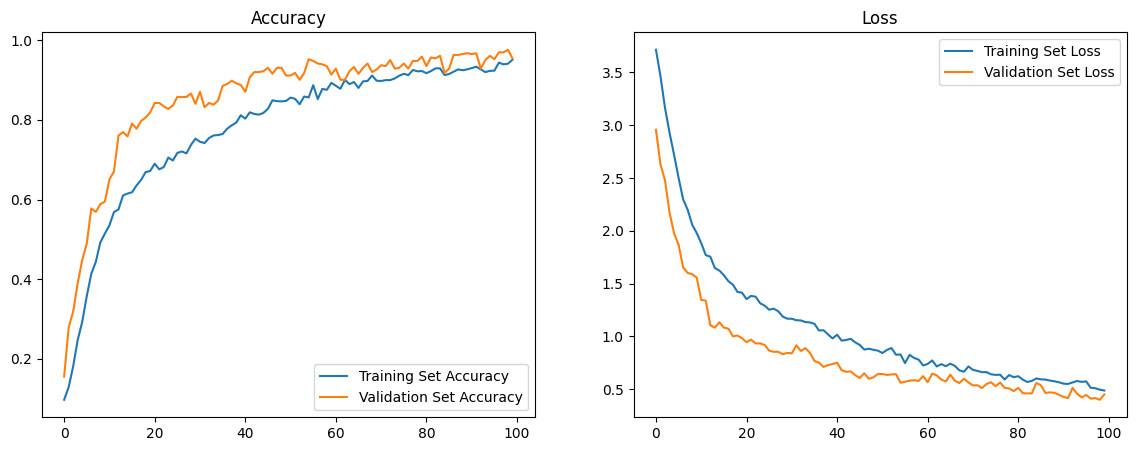

In [12]:
# Plotting model Accuracy and Loss
plt.figure(figsize=(14, 5))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Set Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Set Loss')
plt.plot(history.history['val_loss'], label='Validation Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')

# Show the plots
plt.show()

In [13]:
# Save the trained model in the SavedModel format
saved_model_path = '/content/Money_Detection_model'
model.save(saved_model_path)

In [14]:
# Convert SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = '/content/Money_Detection_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [15]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply default optimization settings during conversion to TensorFlow Lite

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# Load TFLite model
model_path = '/content/Money_Detection_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Specify class names
class_names = {
    0: "100K_Asli",
    1: "100K_Palsu",
    2: "10K_Asli",
    3: "10K_Palsu",
    4: "1K_Asli",
    5: "1K_Palsu",
    6: "20K_Asli",
    7: "20K_Palsu",
    8: "2K_Asli",
    9: "2K_Palsu",
    10: "50K_Asli",
    11: "50K_Palsu",
    12: "5K_Asli",
    13: "5K_Palsu"
}

# Upload the image file
uploaded_images = files.upload()

# Get the image file path
image_path = list(uploaded_images.keys())[0]

# Preprocess the input image
img = Image.open(image_path).resize((128, 128))
img_array = np.array(img) / 255.0  # Normalize to [0, 1]
input_data = np.expand_dims(img_array, axis=0).astype(input_details[0]['dtype'])
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])

# Post-process the output
predicted_class = np.argmax(output_data[0])
confidence = output_data[0][predicted_class]

# Display the result
plt.imshow(img)
plt.title(f'Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.4f}')
plt.axis('off')
plt.show()